<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup:-import-borders,-roads,-..." data-toc-modified-id="setup:-import-borders,-roads,-...-1">setup: import borders, roads, ...</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#import-US-country-and-state-borders" data-toc-modified-id="import-US-country-and-state-borders-1.0.1">import US country and state borders</a></span></li><li><span><a href="#import-roads" data-toc-modified-id="import-roads-1.0.2">import roads</a></span></li></ul></li></ul></li><li><span><a href="#Continental-US-chronomap" data-toc-modified-id="Continental-US-chronomap-2">Continental US chronomap</a></span><ul class="toc-item"><li><span><a href="#call-Google-Maps-for-travel-times" data-toc-modified-id="call-Google-Maps-for-travel-times-2.1">call Google Maps for travel times</a></span></li><li><span><a href="#save/load-data" data-toc-modified-id="save/load-data-2.2">save/load data</a></span></li><li><span><a href="#make-maps-of-travel-times-across-US" data-toc-modified-id="make-maps-of-travel-times-across-US-2.3">make maps of travel times across US</a></span></li><li><span><a href="#make-chronomaps" data-toc-modified-id="make-chronomaps-2.4">make chronomaps</a></span></li><li><span><a href="#animations" data-toc-modified-id="animations-2.5">animations</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Save-figures-and-animations-as-mp4" data-toc-modified-id="Save-figures-and-animations-as-mp4-2.5.0.1">Save figures and animations as mp4</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [1]:
import chronomaps as krm

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from shapely.geometry import Point
from matplotlib.patches import Path, PathPatch, Polygon, Wedge, Circle, Rectangle, FancyBboxPatch
import matplotlib.patheffects as PathEffects

In [3]:
# import mpl_toolkits
# mpl_toolkits.__path__.append('/usr/local/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

In [4]:
import geonamescache
gc = geonamescache.GeonamesCache()
cities_us = [gc.get_cities()[ci] for ci in gc.get_cities().keys() if gc.get_cities()[ci]['countrycode']=='US']

In [5]:
# define green/yellow/red colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('GreenYellowRed',[(0,'limegreen'), (0.5,'gold'),(0.9,'darkred'),(1., 'maroon')])

In [6]:
from shapely.geometry import Point, Polygon

In [7]:
def grid_is_ccUS(grid):
    """Given a list of (lat,lon) points, return only the points that lie within the continental contiguous US"""
    grid_out = [p for p in grid if Polygon(np.array(us_border).T).contains(point)]
    return grid_out    

It turns out that the function above is slower than checking each state (defined below): will go with the latter

In [8]:
def find_in_state(latlon):
    """Given a (lat,lon) pair, find the state that it is inside (using shapely.Polygon.contains() on all the state borders)"""
    point = Point(latlon[1],latlon[0])
    state_flag =[]
    for st in cdf['STUSPS'].tolist():
        state_flag.append(Polygon(np.array(state_border[st]).T).contains(point))
    return np.array(cdf['STUSPS'].tolist())[state_flag]

def grid_is_ccUS(grid):
    """Given a list of (lat,lon) points, return only the points that lie within the continental contiguous
    US (more precisely, within any of the of the lower 48 states)"""
    grid_out = [p for p in grid if len(find_in_state(p))>0]
    return grid_out    

# setup: import borders, roads, ...

### import US country and state borders

US border downloaded from https://www.census.gov/geo/maps-data/data/cbf/cbf_nation.html

In [10]:
import geopandas as gpd

In [11]:
df = gpd.GeoDataFrame.from_file("../input/cb_2017_us_nation_5m.shp")
df.head()

AFFGEOID GEOID           NAME  \
0  0100000US    US  United States   

                                            geometry  
0  (POLYGON ((-176.236246 51.825965, -176.217544 ...

In [12]:
for _, borders in df[['GEOID','geometry']].itertuples(index=False):
    poly = []
    if borders.geom_type == 'MultiPolygon':
        for pol in borders:
            poly.append(pol)
    main_pol = max( poly, key= lambda x: x.area)
us_border = main_pol.exterior.coords.xy

State-level borders

In [13]:
us_df = gpd.GeoDataFrame.from_file("../input/cb_2017_us_state_20m.shp")
us_df = us_df.sort_values('NAME').reset_index(drop=True )
us_df.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD          ALAND  \
0      01  01779775  0400000US01    01     AL     Alabama   00   131174431216   
1      02  01785533  0400000US02    02     AK      Alaska   00  1478588231566   
2      04  01779777  0400000US04    04     AZ     Arizona   00   294198661567   
3      05  00068085  0400000US05    05     AR    Arkansas   00   134768100673   
4      06  01779778  0400000US06    06     CA  California   00   403483182192   

         AWATER                                           geometry  
0    4592944701  POLYGON ((-88.46866248405129 31.8938557116156,...  
1  277723861311  (POLYGON ((-173.074642 60.704657, -172.912636 ...  
2    1027245114  POLYGON ((-114.799683 32.593621, -114.809393 3...  
3    2963631791  POLYGON ((-94.617919 36.499414, -94.3612029999...  
4   20484637928  (POLYGON ((-118.593969 33.467198, -118.484785 ...

In [14]:
# continental contiguous US
cdf = us_df.loc[~us_df['NAME'].isin( ['Hawaii', 'Alaska','Puerto Rico'])]

Extract main border (by land area) of each state, forget about minor islands for rest of exercise

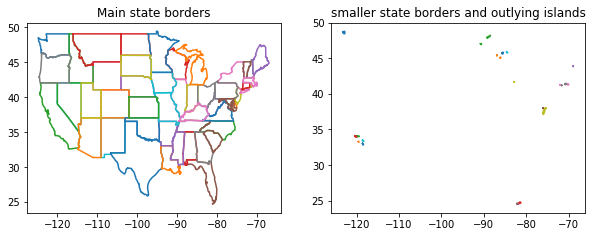

In [20]:
state_border = {}
minor_borders = {}
fig, axes = plt.subplots(1,2,figsize=(10,3.5))
for st,borders in cdf[['STUSPS','geometry']].itertuples(index=False):
    poly = []
    if borders.geom_type == 'MultiPolygon':
        for pol in borders:
            poly.append(pol)
    else:
        poly.append(borders)
    main_pol = max( poly, key= lambda x: x.area)
    
    state_border[st] = main_pol.exterior.coords.xy
    minor_borders[st] = []
    for pol in poly:
        if pol != main_pol: minor_borders[st].append(pol.exterior.coords.xy)

# Re-unite Michigan upper peninsula:
# find closest coordinate pairs between main MI and upper MI
closest = sorted([[p1,p2, (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 ]  for p1 in zip(*state_border['MI']) for p2 in zip(*minor_borders['MI'][4])], key =lambda x: x[-1])[0]
x0=np.where(np.array(state_border['MI']).T == closest[0])[0][0]
x1=np.where(np.array(minor_borders['MI'][4]).T == closest[1])[0][0]
# reorder the coordinates
cc1 = zip(*map(lambda x: np.roll(x, -x0), state_border['MI']))
cc2 = zip(*map(lambda x: np.roll(x, -x1), minor_borders['MI'][4]))
# redefine MI border with both pieces
state_border['MI'] = zip(*(cc1+cc2))
minor_borders['MI'].pop(4)

for st in state_border.keys():
    axes[0].plot(*state_border[st])
    for pol in minor_borders[st]:
        axes[1].plot(*pol)
axes[0].set_title('Main state borders')
axes[1].set_title('smaller state borders and outlying islands');

### import roads

We will superimpose roads on top of map of US. Donwload geodataframe from https://catalog.data.gov/dataset/tiger-line-shapefile-2016-nation-u-s-primary-roads-national-shapefile

In [21]:
import geopandas as gpd
hwydf = gpd.GeoDataFrame.from_file('../input/tl_2016_us_primaryroads.dbf')
hwydf.head()

LINEARID          FULLNAME RTTYP  MTFCC  \
0  1105647111403  Morgan Branch Dr     M  S1100   
1  1103662626368       Biddle Pike     M  S1100   
2  1103662626717   Cincinnati Pike     M  S1100   
3  1105056901124            I- 405     I  S1100   
4  1105056901128            I- 405     I  S1100   

                                            geometry  
0  LINESTRING (-75.61562299999999 38.625174, -75....  
1  LINESTRING (-84.56701699999999 38.360526, -84....  
2  LINESTRING (-84.568051 38.348926, -84.56800899...  
3  LINESTRING (-122.679601 45.54082199999999, -12...  
4  LINESTRING (-122.670959 45.506849, -122.671025...

In [23]:
roads_long = []
for i, hwy in hwydf[hwydf['RTTYP']=='I'][:].iterrows():
    tmp = list(hwy['geometry'].coords)
    if krm.is_in_range(tmp[0],[-126,-63],[24,50]): # removes roads in Hawaii
        roads_long.append([hwy['FULLNAME'], tmp])
print len(roads_long)

6007


We will only make US-wide images, so we do not need super-precise coordinates. Here I just shorten each road segment by picking one coordinate pair every N.

In [24]:
roads = []
for name, road in roads_long:
    if len(road)<4: nn=1
    else: nn=len(road)/4
    roads.append([name,road[::nn]]) 

[1646417, 28097]


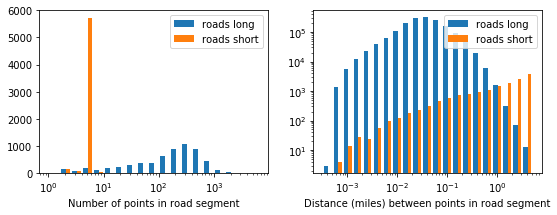

In [25]:
print map(sum,[[len(road) for name, road in roads_long], [len(road) for name, road in roads]])
delta_list = [ krm.get_distance(reversed(road[i]),reversed(road[i+1])) for name, road in roads_long for i in range(len(road)-1)]
delta_list1 = [ krm.get_distance(reversed(road[i]),reversed(road[i+1])) for name, road in roads for i in range(len(road)-1)]

fig, axes=plt.subplots(1,2,figsize=(9,3))
axes[0].hist([[len(road) for name, road in roads_long ],[len(road) for name, road in roads]],  
               histtype='bar', bins=10**np.arange(0,4,0.2))
axes[0].set_xlabel('Number of points in road segment')

axes[1].hist([delta_list, delta_list1], log=True, histtype='bar', bins=10**np.arange(-3.5,0.8,0.2))
axes[1].set_xlabel('Distance (miles) between points in road segment')
for ax in axes: 
    ax.set_xscale('log')
    ax.legend(('roads long','roads short'),loc='upper right', bbox_to_anchor=(1,1));

Plot all the roads: there is still 28000 distinct segments, so it takes a while for matplotlib

CPU times: user 42.4 s, sys: 770 ms, total: 43.2 s
Wall time: 44.8 s


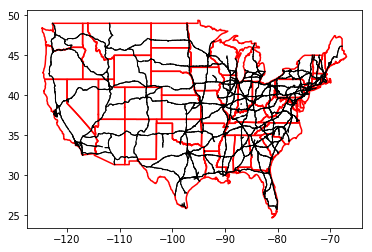

In [26]:
%%time
for st in state_border.keys():
    plt.plot(*state_border[st], c='r') 
for name, road in roads:
    plt.plot(*zip(*road), c='k', lw=1)

# Continental US chronomap

In [37]:
themap = Basemap(llcrnrlon=-122, llcrnrlat=23, urcrnrlon=-63, urcrnrlat=48, epsg=2163, resolution='l')
themap0 = Basemap(llcrnrlon=-126,llcrnrlat=24,urcrnrlon=-63,urcrnrlat=50, projection='cyl', resolution='l')

Make a grid that covers the continental US, and then throw away points that are not on land or outside the US border

In [ ]:
pos0=[39.8283459,-98.5794797]

In [38]:
%%time
nx, ny = 100, 55
nx = (int(nx/(1+1.2)),int(nx*1.2/(1+1.2)))
ny = (int(ny/(1+0.6)),int(ny*.6/(1+0.6)))
grid0 = krm.make_xy_grid(pos0, max_time=(1600,900), nx=nx, ny=ny, max_speed=1 )
grid1 = krm.grid_is_land(grid0, themap=themap0)
grid = grid_is_ccUS(grid1)
print len(grid0), len(grid1), len(grid)

5346 3383 2714
CPU times: user 48.4 s, sys: 621 ms, total: 49.1 s
Wall time: 51.8 s


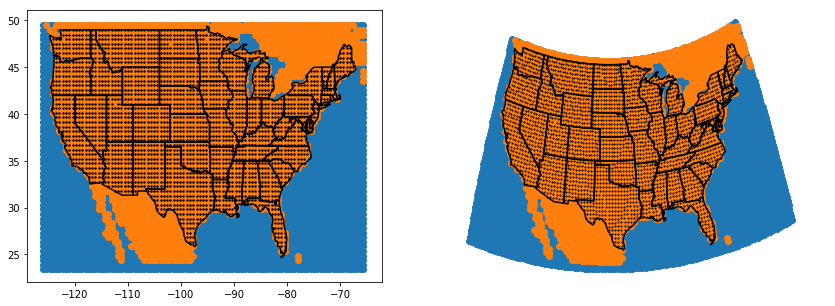

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.scatter(*reversed(zip(*grid0))) # reversed: lat,lon -> y,x
ax1.scatter(*reversed(zip(*grid1)))
ax1.scatter(*reversed(zip(*grid)), s=2, c='k')
ax2.set_axis_off()
ax2.scatter(*themap(*reversed(zip(*grid0))))
ax2.scatter(*themap(*reversed(zip(*grid1))))
ax2.scatter(*themap(*reversed(zip(*grid))),s=1, c='k')
for st in state_border.keys():
    ax1.plot(*state_border[st], c='k') 
    ax2.plot(*themap(*state_border[st]), c='k') 

## call Google Maps for travel times

Given the grid defined above, we compute travel times to each point from three locations, Los Angeles, the center of the United States, and New York City

In [40]:
cities_list = ['Los Angeles','US center', 'New York City']
short_name_list = ['LA','center','NY']
# pos0_list = [ krm.call_Gmaps_coords_from_address(city) for city in cities_list ]
pos0_list=[0]*len(cities_list)
for idx, name in enumerate(cities_list):
    try:
        city = [ci for ci in cities_us if name == ci['name']][0]
        pos0_list[idx]= [city['latitude'], city['longitude']]
    except: idx=1
pos0_list[1] = [39.8283459, -98.5794797] 
pos0_list

[[34.05223, -118.24368], [39.8283459, -98.5794797], [40.71427, -74.00597]]

In [54]:
themap.epsg

2163

In [53]:
reload(krm)

<module 'chronomaps' from 'chronomaps.py'>

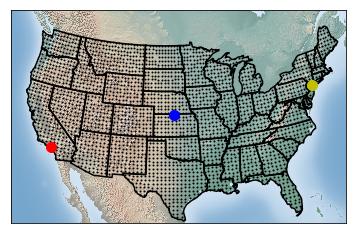

In [55]:
y, x = zip(*grid)
fig = krm.make_grid_map(x,y, themap = themap, s=1,c='k')
ax = fig.gca()
for st in state_border.keys():
    ax.plot(*themap(*state_border[st]), c='k') 
for i,p in enumerate(pos0_list):
    ax.scatter(*themap(*reversed(p)), s=100, zorder=10, c=['r','b','y'][i])

In [56]:
print 'points in grids:', len(grid)

points in grids: 2714


Run Google Maps API for each starting location on the same grid

In [47]:
dists_list, times_list = [], []
for idx in range(len(pos0_list)):
    gg, tt, dd = krm.run_travel_grid(pos0_list[idx], grid)
    dists_list.append(dd)
    times_list.append(tt)

## save/load data

In [57]:
# protects from inadvertedly overwriting the saved data
flag_save = not True
if flag_save:
    np.savez('data/grid_us_times.npz', grid=grid, dists=dists_list, times=times_list)

In [59]:
npzinput = np.load('data/grid_us_times.npz')
grid = npzinput['grid']
dists_list = npzinput['dists']
times_list = npzinput['times']

## make maps of travel times across US

In [79]:
def make_contour_map(x,y,z, levels, ax, pos0, projmap, service='', plot_states=True, plot_roads=True, roads='', mask_out=True, cbarlabel='Travel time (hours)'):
    """
    Given an x,y grid with values z for each point, plot contours of constant z at the specified levels.
    Additional required arguments are:
        - ax: which axes instance to plot on
        - pos0: departure point to be plotted with an x
        - projmap: Basemap projection map instance
    Optional arguments:
        - service: Basemap background map layer to plot. Any ArcGIS service (e.g. 'World_Street_Map', 'ESRI_StreetMap_World_2D','NatGeo_World_Map', ...)
          if service is not found, defaults to shadedrelief method
        - plot_states, plot_roads: if True, plot US state borders, US interstates. If plot_roads=True, list of roads coordinates should be provided to roads argument.
        - cbarlabel: add colorbar and label unless cbarlabel='', in which case no colorbar is plotted
        - mask_out: if True, cover outside of US border with white patch
    """
    z = np.array(z)
    cols = [cmap(1.*lev/levels[-1]) for lev in levels]
        
    if service != '': 
        try: projmap.arcgisimage(service=service, ax=ax)
        except: projmap.shadedrelief(ax=ax)
    
    if plot_roads and roads=='':
        plot_roads = False
    
    if plot_states:
        for st in state_border.keys():
            ax.plot(*projmap(*state_border[st]),c='k',zorder=2)
    
    if plot_roads:
        for name, road in roads:
            ax.plot(*projmap(*zip(*road)), c='0.5',lw=0.5)

    xm, ym = projmap(x,y)
    
    ax.scatter(*projmap(pos0[1],pos0[0]), marker='x',c='b', s=20, zorder=100)
    ax.tricontour(xm,ym,z, levels=levels, colors=map(lambda c: krm.lighten_color(c,1.2), cols),linewidths=1,zorder=2)
    im = ax.tricontourf(xm,ym,z, levels=levels, colors=cols, alpha=0.5, antialiased=True,extend='max',zorder=2)
    if cbarlabel!='':
        cb = plt.colorbar(im, ax=ax, label=cbarlabel, fraction=0.045, extendfrac=0.04, extendrect=True, shrink=0.85)
        cb.set_alpha(0.7)
        cb.draw_all()
    
    # mask out anything that is not US
    if mask_out:
        patch = krm.mask_outside_polygon(zip(*projmap(*us_border)), ax=ax, facecolor='w', edgecolor='k',zorder=20)
        ax.add_patch(patch)
    
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    return ax

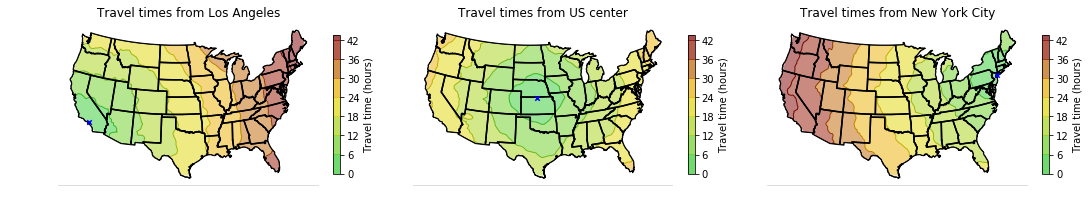

In [80]:
fig, axes = plt.subplots(1,3,figsize=(18,3))
levels = range(0,44,6)
cols = [cmap(1.*lev/levels[-1]) for lev in levels]

for idx, ax in enumerate(axes):
    pos0 = pos0_list[idx]
    y, x = zip(*grid)
    z = np.array(times_list[idx])/60./60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60/60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    
    ax = make_contour_map(xx,yy,zz, ax=ax, pos0=pos0_list[idx], projmap=themap, levels=levels, roads='', service='')
    ax.set(aspect=1, title='Travel times from '+cities_list[idx])

## make chronomaps

In [82]:
def morph(pp, p0, func, projmap=''):
    """
    Chronomap function: remaps point pp keeping same angle from origin p0 and rescaling radial distance to func(pp), where func will 
    typically return the travel time from p0 to pp.
    Inputs pp, p0 should be (lon,lat) coordinates. If projmap='', compute angles between (lon,lat) points, otherwise 
    between projection coordinate points defined by the projection map passed in input.
    """
    (dy, dx) = (pp[1]-p0[1], pp[0]-p0[0]) if projmap=='' else (projmap(*pp)[1]-projmap(*p0)[1], projmap(*pp)[0]-projmap(*p0)[0])
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    new_r = func(pp) # new radius
    return np.array([new_r*np.cos(theta), new_r*np.sin(theta)])

In [83]:
from scipy.interpolate import interp2d, NearestNDInterpolator, LinearNDInterpolator, Rbf

In [91]:
func4 = Rbf(xx,yy,zz, function='linear')
p0 = list(reversed(pos0_list[idx]))

def time_func(pp):
    res = func4(*pp)
    return res

Note: defined this way, I can change the interpolating function func4 (e.g. giving it different times from different starting points) and time_func will be referring to the updated function.

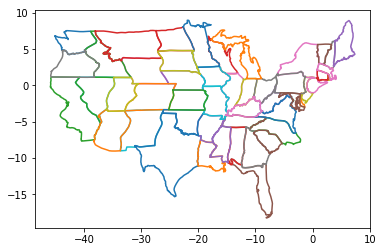

In [94]:
for st in state_border.keys():
    mbo = [morph(pp, p0, time_func, projmap=['',themap][0]) for pp in zip(*state_border[st])]
    plt.plot(*zip(*mbo))

This is a chronomap of the US given a New York as a starting point. The distances are measured in hours (for example it takes about 40 hours from New York to San Francisco.

I will make nicer plots including travel time contours below, as I will reuse the functions to make animations.

## animations

I want to make animations where a normal map stretches into the chronomap in a discrete number of steps. For that, I create an interpolating function which interpolates between distance and time as one changes x from 0 to 1. See the effect below the definition.

In [95]:
def interp_func(pp, p0, xstep, rescale_rt, projmap=''):
    """
    Function that linearly interpolates between (normalized) geographical distance and travel time, with xstep in the [0,1] range
    Input argument rescale_rt are the max Euclidean distance and travel time for points in the grid, used to normalize the inputs.
    """
    rescale_r, rescale_t = rescale_rt
    pp_time = time_func(pp)/rescale_t
    if projmap != '': pp, p0 = projmap(*pp), projmap(*p0)
    pp_dist = np.sqrt((pp[0]-p0[0])**2+(pp[1]-p0[1])**2)/rescale_r
    return pp_dist*(1.-xstep) + pp_time*xstep

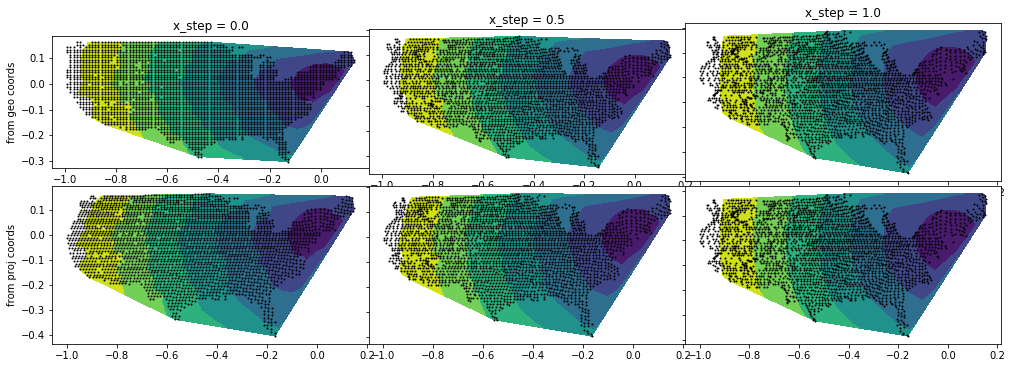

In [96]:
rescale_r = np.sqrt(max([(pp[0]-p0[0])**2+(pp[1]-p0[1])**2 for pp in zip(xx,yy)]))
rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])

fig, axes = plt.subplots(2,3,figsize=(17,6))
for iax, ax in enumerate(axes[0]):
    x1, y1 = zip(*[ morph(pp, p0, lambda pp: interp_func(pp,p0, 1.*iax/(len(axes[0])-1), [rescale_r, rescale_t])) for pp in zip(xx,yy)])
    ax.tricontourf(x1,y1,zz, levels=levels)
    ax.scatter(x1,y1,s=1,c='k')
    ax.set_title('x_step = '+str(1.*iax/(len(axes[0])-1)))
    ax.set_aspect(1)
    if iax>0: ax.set_yticklabels([])

rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
for iax, ax in enumerate(axes[1]):
    x1, y1 = zip(*[ morph(pp, p0, lambda pp: interp_func(pp,p0, 1.*iax/(len(axes[1])-1), [rescale_r, rescale_t], projmap=themap)) for pp in zip(xx,yy)])
    ax.tricontourf(x1,y1,zz, levels=levels)
    ax.scatter(x1,y1,s=1,c='k')
    ax.set_aspect(1)
    if iax>0: ax.set_yticklabels([])
axes[0][0].set(ylabel='from geo coords');
axes[1][0].set(ylabel='from proj coords');
fig.subplots_adjust(wspace=0, hspace=0)

From left to right, see how the normal map (and the underlying rectangular grid) gets stretched, and how the travel time become perfect circles (by construction).    
Note also that now the x,y ranges are normalized to 1.

In [ ]:
# make my own colorbar function (see how it looks down below)
def make_filling_colorbar(ax, pos_cbar, fine_lev, levels, dx = 0.035, dy = 0.05, fill_coarse_levels=False):
    p_bbox = FancyBboxPatch(pos_cbar, 2*dx, dy*len(levels), boxstyle="round,pad="+str(dx/1.5),ec="gray", fc="0.95", transform=ax.transAxes, zorder=10**3-1)
    ax.add_patch(p_bbox)

    tmp = [ list(fine_levels).index(l) for l in fine_levels if l in levels]
    patch=[]
    cbarlabels=[]
    max_value = levels[-1] + (levels[-1]-levels[-2])    
    for ilev in range(list(fine_levels).index(fine_lev)):
        if fine_levels[ilev] < max_value: 
            col=cmap(1.*fine_levels[ilev]/levels[-1])
            ax.add_patch(Rectangle((pos_cbar[0],pos_cbar[1]+ilev*dy/(tmp[1]-tmp[0])),dx, dy/(tmp[1]-tmp[0]), linewidth=2, edgecolor='none',facecolor=col, alpha=0.7,transform=ax.transAxes, zorder=10**3))
    for ilev,lev in enumerate(levels):
        col = cmap(1.*lev/levels[-1])
        facecolor = col if fill_coarse_levels else 'none'
        col = krm.lighten_color(col,1.2)
        ax.add_patch(Rectangle((pos_cbar[0],pos_cbar[1]+ilev*dy),dx,dy, linewidth=2, edgecolor=col, facecolor=facecolor, zorder=10**3,transform=ax.transAxes))
        if ilev%2==0:
            ax.annotate(str(lev)+'h',xy=(pos_cbar[0]+1.1*dx,pos_cbar[1]+ilev*dy-dy/5),  xycoords='axes fraction' ,ha='left',zorder=10**3)

    return ax

I here define two functions:
- `animate_fill(i, ax)` - it makes a standard map (with `World_Physical_Map` ArcGIS background) and fills with color up to travel time defined by `fine_levels[i]`. It also draws all contours in `norm_levels` which are below the currently plotted time. 
- `animate_chronomap(i, ax)` - it draws a map such that when i=0 I get a standard map, when i=morph_steps I get the chronomap, and otherwise I have a linearly interpolated map between the two. Fixed travel time contours are filled according to `norm_levels`.

In [103]:
def animate_fill(i, ax):
    ax.clear()
    
    themap.arcgisimage(service='World_Physical_Map',xpixels=800, ax = ax)
    
    xm, ym = themap(xx,yy)
    
    cols = [cmap(1.*lev/norm_levels[-1]) for lev in norm_levels]
    levs = [lev for lev in norm_levels if lev <= fine_levels[i]]
    if len(levs)>1: 
        ax.tricontour(xm,ym,zz,levels=levs, colors=map(lambda c: krm.lighten_color(c,1.2), cols[:norm_levels.index(levs[-1])]),linewidths=1)
    if i>0:
        ax.tricontourf(xm,ym,zz,levels=fine_levels[:i+1],colors=fine_cols[:i+1], alpha=0.5, antialiased=True)
    
    if i<len(fine_levels)-1:
        txt = ax.annotate('Travel time: '+str(fine_levels[i])+'h', xy = pos_txt, 
                    xycoords='axes fraction', va='bottom',zorder=101)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='gray')])    

    ax = make_filling_colorbar(ax, pos_cbar, fine_levels[i], norm_levels, dx=dx, dy=dy)
    
    # center origin: p0 ± (x_span, y_span)
    if isinstance(x_span, list) and len(x_span)==2: # fix if asymmetrical
        ax.set(xlim=(pm0[0]-x_span[0], pm0[0]+x_span[1] ), ylim=(pm0[1]-y_span[0], pm0[1]+y_span[1]))
    else: ax.set(xlim=(pm0[0]-x_span, pm0[0]+x_span ), ylim=(pm0[1]-y_span, pm0[1]+y_span ));

In [179]:
def animate_chronomap(i, ax):
    ax.clear()
    func = lambda pp: interp_func(pp,p0, 1.*i/morph_steps, [rescale_r, rescale_t], projmap=themap)
    
    # fix origin and span to match with previous frames:
    if isinstance(x_span, list) and len(x_span)==2: # fix if asymmetrical
        ax.set(xlim=(-x_span[0]/rescale_r, x_span[1]/rescale_r), ylim=(-y_span[0]/rescale_r, y_span[1]/rescale_r), aspect=1)
    else: ax.set(xlim=(-x_span/rescale_r, x_span/rescale_r), ylim=(-y_span/rescale_r, y_span/rescale_r), aspect=1)
    
    cols = [cmap(1.*lev/norm_levels[-1]) for lev in norm_levels]
    if i==morph_steps:
        for ilev, lev in enumerate(norm_levels):
            col=cmap(1.*lev/norm_levels[-1])
            dlev = (norm_levels[1]-norm_levels[0])/rescale_t
            lev = lev/rescale_t
            ax.add_patch(Wedge((0,0),lev+dlev,0,360,width=dlev,facecolor=col,edgecolor=col,alpha=0.5))
            ax.add_patch(Circle((0,0),lev+dlev,facecolor='none',edgecolor='gray',zorder=4,lw=0.5,alpha=0.5))

    else:
        mgrid = [ morph(pp, p0, func, projmap=themap) for pp in zip(xx,yy)]
        x1, y1 = zip(*mgrid)
        ax.tricontour(x1,y1,zz, levels=norm_levels, colors=map(lambda c: krm.lighten_color(c,1.2), cols),linewidths=1,zorder=2)
        ax.tricontourf(x1,y1,zz, levels=norm_levels, colors=cols, alpha=0.5, antialiased=True,extend='max',zorder=2)
    
    if plot_my_colorbar: ax = make_filling_colorbar(ax, pos_cbar, fine_levels[-1], norm_levels, dx=dx, dy=dy, fill_coarse_levels=True)
    
    if isinstance(x_span, list) and len(x_span)==2: # fix if asymmetrical
        ax.set(xlim=(-x_span[0]/rescale_r, x_span[1]/rescale_r), ylim=(-y_span[0]/rescale_r, y_span[1]/rescale_r), aspect=1)
    else: ax.set(xlim=(-x_span/rescale_r, x_span/rescale_r), ylim=(-y_span/rescale_r, y_span/rescale_r), aspect=1)



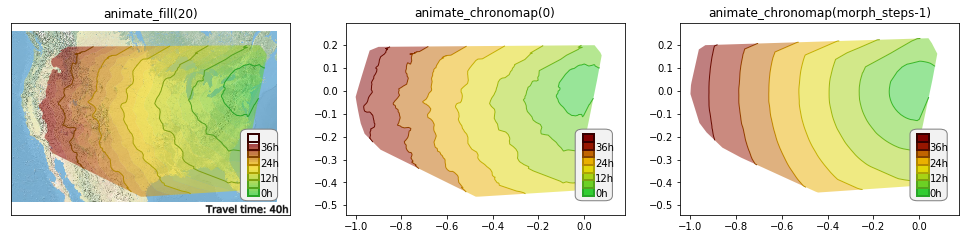

In [163]:
norm_levels = levels
fine_levels = np.arange(0,52,2)
fine_cols = [cmap(1.*lev/norm_levels[-1]) for lev in fine_levels]
morph_steps=20


x_range = (-121,-59) 
y_range = (21,48)
p0 = [pos0[1], pos0[0]]
pm0 = themap(*p0)
pos_cbar = [0.85, 0.1]
pos_txt = [0.7,0]
dx, dy = 0.04, 0.04
plot_my_colorbar = True

x_span, y_span = map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]), map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1])
rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])

fig, axes = plt.subplots(1,3,figsize=(17,4))
animate_fill(20, ax=axes[0])
animate_chronomap(0, ax=axes[1])
animate_chronomap(morph_steps-1, ax=axes[2])

for iax,ax in enumerate(axes):
    ax.set(title=['animate_fill(20)','animate_chronomap(0)','animate_chronomap(morph_steps-1)'][iax])

Note that we did not put any borders or roads in in order not to write very similar code twice in each function.

We now define a function below, `animate_all(i)`, defined for `i=-len(fine_levels), ... , 0 , ... , morph_steps`, such that:
- for `i=-len(fine_levels), ... , -1)`, fills the standard map with an increasing blob of color as the travel time increases by calling `animate_fill`
- for `i=0, ... , morph_steps`, transforms the standard map into a chronomap, by calling `animate_chronomap`
- finally, it adds all the recognizable layers such as states, roads, and masks the outside of the US with a white layer. By default roads are not plotted as it takes a while. I will turn it on with plot_roads=True when I want to save the output plots and animations.

See how `animate_all` works in the plot row in the cell below its definition.

In [131]:
def animate_all(i, ax, plot_roads=False):
    if i >= morph_steps: i = morph_steps # hang on with last frame

    if -len(fine_levels)<= i <0: 
        animate_fill(len(fine_levels)+i, ax)
        func = lambda pp: np.sqrt((themap(*p0)[1]-themap(*pp)[1])**2+(themap(*p0)[0]-themap(*pp)[0])**2)
        projmap = themap
        origin = np.array(themap(*p0))
    elif 0 <= i <= morph_steps:
        animate_chronomap(i, ax)
        func = lambda pp: interp_func(pp, p0, 1.*i/morph_steps, [rescale_r, rescale_t], projmap=themap)
        projmap= themap
        origin =(0,0)

    ax.scatter(*origin, marker='x',c='k', s=20, zorder=100)

    if True: #always plot_states 
        for st in state_border.keys():
            mbo = [ origin + morph(pp, p0, func, projmap=projmap) for pp in zip(*state_border[st])]
            #mbo = [ morph(pp, p0, func, projmap=themap) for pp in zip(*state_border[st])]
            ax.plot(*zip(*mbo),c='k',lw=1,zorder=2)

    if plot_roads: #plot_roads
        for name, road in roads:
            mbo = [origin + morph(pp, p0, func, projmap=projmap) for pp in road]
            ax.plot(*zip(*mbo), c='0.5',lw=.5,zorder=2)

    if True: #fill US outline
        mborder = [ origin + morph(pp, p0, func, projmap=projmap) for pp in zip(*us_border)]
        patch = krm.mask_outside_polygon(mborder, ax=ax, facecolor='w', edgecolor='k',zorder=3)
        ax.add_patch(patch)
    
    ax.set_axis_off()

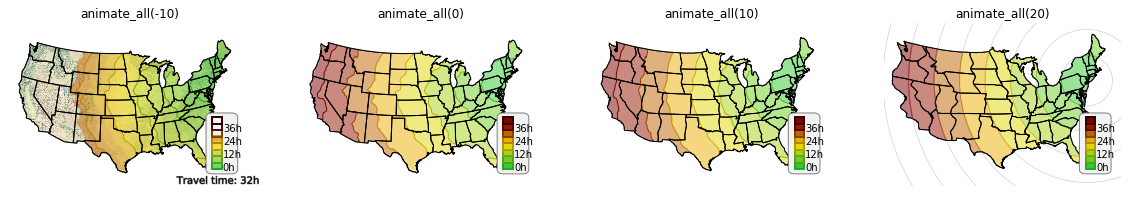

In [164]:
fig, axes = plt.subplots(1,4,figsize=(20,3))

for iax,ax in enumerate(axes):
    istep = [-10,0,10,20][iax]
    animate_all(istep, ax=ax)
    ax.set(title='animate_all({})'.format(istep))

We are now ready to run and save an animation using matplotlib's animation package. 

First we test the animation by displaying it inline in the notebook and without roads (NB: it takes a while - here I took one every two frames with `frames=frames[::2]` ).

In [141]:
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
rc('animation', html='html5')
rc('animation', embed_limit=200.)

In [165]:
fig = plt.figure(figsize=(5,round(5*sum(y_span)/sum(x_span),2)))
ax = plt.Axes(fig, [0., 0., 1., 1.]) # works much better than subplots_adjust
fig.add_axes(ax)
ax.set_axis_off()

plot_my_colorbar = True
pos_cbar = [0.9, 0.08]
pos_txt = [0.77,0]
dx=0.035

frames = sorted(range(-len(fine_levels),morph_steps+1)+[0]*3+[morph_steps]*5)
anim = animation.FuncAnimation(fig, animate_all, frames=frames[::2], fargs=(ax,), interval=200); plt.close(); 

In [166]:
%%time
HTML(anim.to_jshtml())

CPU times: user 2min 33s, sys: 3.36 s, total: 2min 36s
Wall time: 3min 27s


#### Save figures and animations as mp4

No need to display anything. First we save the isochrones map, the chronomap and a combination of the two.

In [170]:
%%time
x_range = (-121,-59) 
y_range = (21,48)
x_span, y_span = map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]), map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1])
pos_cbar=[0.9, 0.08]
pos_txt = [0.85, 0]
plot_roads = True

for idx in range(len(cities_list)):
    levels = [range(0,48, 6), range(0,28,3)][idx%2]
    dx, dy = 0.02, 0.04
    plot_my_colorbar = True
    norm_levels = levels
    fine_levels = [np.arange(0,52,2), np.arange(0,31,1)][idx%2]
    fine_cols = [cmap(1.*lev/norm_levels[-1]) for lev in fine_levels]
    
    pos0 = pos0_list[idx]
    y, x = zip(*grid)
    z = np.array(times_list[idx])/60./60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60/60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    # force origin to be zero departure time instead of averaging nearby points
    xx, yy, zz = xx + (pos0[1],), yy + (pos0[0],), np.append(zz,0)

    func4 = Rbf(xx,yy,zz, function='linear')

    p0 = list(reversed(pos0))
    pm0 = themap(*p0) 
    x_span, y_span = map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]), map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1])

    morph_steps = 20
    rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
    rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])

    fig = plt.figure(figsize=(9,round(9*np.mean(y_span)/np.mean(x_span),2)))
    ax = plt.Axes(fig, [0., 0., 1., 1.]) # works much better than subplots_adjust!!
    ax.set_axis_off()
    fig.add_axes(ax)
    animate_all(-1, ax, plot_roads=plot_roads)
    fig.savefig('figs/travel_times_US_from_'+short_name_list[idx]+'.png');plt.close();
    animate_all(100, ax, plot_roads=plot_roads)
    fig.savefig('figs/chronomap_US_from_'+short_name_list[idx]+'.png');plt.close();
    
    plot_my_colorbar = False
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13, 4.1))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.)
    ax1.clear()
    make_contour_map(xx,yy,zz, ax=ax1, pos0=pos0, projmap=themap, plot_roads=plot_roads, levels=levels, roads=roads, service='')
    ax1.set(aspect=1)
    # animate_all(0, ax1, plot_roads=True)
    animate_all(100, ax2, plot_roads=plot_roads)
    fig.savefig('figs/chronomap_US_from_'+short_name_list[idx]+'_combined.png')
    plt.close();
plt.close();

CPU times: user 11min 15s, sys: 20.5 s, total: 11min 36s
Wall time: 12min 48s


Now make animations and save them as MP4. This takes a very long time (2-3 hours if plot_roads=True), so go have fun outside...

In [187]:
%%time
x_range = (-121,-59) 
y_range = (21,48)
x_span, y_span = map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]), map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1])
pos_cbar=[0.9, 0.08]
pos_txt = [0.85, 0]
dx, dy =0.02, 0.04
plot_my_colorbar = True
plot_roads = True

for idx in [1,2]:
# for idx in range(len(cities_list)):
    levels = [range(0,48, 6), range(0,25, 6)][idx%2]
    norm_levels = levels
    fine_levels = [np.arange(0,52,2), np.arange(0,32,2)][idx%2]
    fine_cols = [cmap(1.*lev/norm_levels[-1]) for lev in fine_levels]
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    pos0 = pos0_list[idx]
    y, x = zip(*grid)
    z = np.array(times_list[idx])/60./60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60/60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    xx, yy, zz = xx + (pos0[1],), yy + (pos0[0],), np.append(zz,0)

    func4 = Rbf(xx,yy,zz, function='linear')

    p0 = list(reversed(pos0_list[idx]))
    pm0 = themap(*p0) 
    x_span, y_span = map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]), map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1])

    morph_steps = 20
    rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
    rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])

    fig = plt.figure(figsize=(9,round(9*np.mean(y_span)/np.mean(x_span),2)))
    ax = plt.Axes(fig, [0., 0., 1., 1.]) # works much better than subplots_adjust!!
    ax.set_axis_off()
    fig.add_axes(ax)
    
    frames = sorted(range(-len(fine_levels),morph_steps+1)+[0]*3+[morph_steps]*5)
    # pass args to animate function: fargs(ax, True)
    
    anim = animation.FuncAnimation(fig, animate_all, frames=frames[::], fargs=(ax, plot_roads), interval=100); plt.close();
    if plot_roads: anim.save('animations/animation_US_'+short_name_list[idx]+'.mp4')
    else: anim.save('animations/animation_US_'+short_name_list[idx]+'_no_roads.mp4')
    plt.close()
    print cities_list[idx], ', ', 
plt.close();
print ''

US center ,  New York City ,  
CPU times: user 1h 37min 49s, sys: 46.1 s, total: 1h 38min 35s
Wall time: 1h 41min 42s
